# KNN Classifier-V6
### Use cross-validation

## Import

In [8]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

## The Dataset

In [9]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

data = pd.read_csv('/Users/fengyuexin/Desktop/Data mining homework/adult.data', names=column_names, sep=',\s', engine='python', na_values="?")
data_test = pd.read_csv('/Users/fengyuexin/Desktop/Data mining homework/adult.test', names=column_names, sep=',\s', engine='python', na_values="?", skiprows=1)

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/var/folders/jm/47w2qsqx3tg66cd69qk5kldw0000gn/T/ipykernel_91612/1523703274.py:7: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv('/Users/fengyuexin/Desktop/Data mining homework/adult.data', names=column_names, sep=',\s', engine='python', na_values="?")
/var/folders/jm/47w2qsqx3tg66cd69qk5kldw0000gn/T/ipykernel_91612/1523703274.py:8: SyntaxWarning: invalid escape sequence '\s'
  data_test = pd.read_csv('/Users/fengyuexin/Desktop/Data mining homework/adult.test', names=column_names, sep=',\s', engine='python', na_values="?", skiprows=1)


## Data preprocessing

In [10]:
# Delete missing values
data = data.dropna()
data_test = data_test.dropna()


# One-Hot Encoding
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

encoder = OneHotEncoder(sparse_output=False, drop='first')

X_train_encoded = encoder.fit_transform(data[categorical_columns])
X_test_encoded = encoder.transform(data_test[categorical_columns])

encoded_feature_names = encoder.get_feature_names_out(categorical_columns)

X_train = pd.DataFrame(X_train_encoded, columns=encoded_feature_names)
X_test = pd.DataFrame(X_test_encoded, columns=encoded_feature_names)

X_train_continuous = data[['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']].reset_index(drop=True)
X_test_continuous = data_test[['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']].reset_index(drop=True)

X_train = pd.concat([X_train_continuous, X_train], axis=1)
X_test = pd.concat([X_test_continuous, X_test], axis=1)

# Tag processing
y_train = data['income'].apply(lambda x: 1 if x == '>50K' else 0).reset_index(drop=True)
y_test = data_test['income'].apply(lambda x: 1 if x == '>50K' else 0).reset_index(drop=True)


# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Oversample the training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
X_test_array = X_test.to_numpy() 
X_train_resampled = np.array(X_train_resampled)
y_train_resampled = np.array(y_train_resampled)

if y_train_resampled.ndim > 1:
    y_train_resampled = y_train_resampled.ravel()

# Check the distribution of categories after oversampling
print(f"Original dataset shape: {Counter(y_train)}")
print(f"Resampled dataset shape: {Counter(y_train_resampled)}")

Original dataset shape: Counter({0: 22654, 1: 7508})
Resampled dataset shape: Counter({0: 22654, 1: 22654})


## Implementation of KNN algorithm

In [11]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def knn(X_train, y_train, X_test, k=5):
    predictions = []
    
    for idx, test_point in enumerate(tqdm(X_test, desc="Predicting", unit="sample")):
        distances = []

        for i, train_point in enumerate(X_train):
            dist = euclidean_distance(train_point, test_point)
            distances.append((dist, y_train[i]))

        k_neighbors = sorted(distances, key=lambda x: x[0])[:k]
        k_labels = [label for _, label in k_neighbors]

        most_common = Counter(k_labels).most_common(1)[0][0]
        predictions.append(most_common)

    return np.array(predictions)

# Perform cross-validation
def cross_validate_knn(X, y, k, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1_scores = []

    for train_index, val_index in tqdm(kf.split(X), total=n_splits, desc="Cross-validating"):
        X_train_cv, X_val_cv = X[train_index], X[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]
        
        y_pred_cv = knn(X_train_cv, y_train_cv, X_val_cv, k=k)
        f1 = f1_score(y_val_cv, y_pred_cv, average='weighted')
        f1_scores.append(f1)

    return f1_scores

# Run KNN
k = 10
cv_scores = cross_validate_knn(X_train_resampled, y_train_resampled, k)

print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1 score: {np.mean(cv_scores):.3f} (+/- {np.std(cv_scores) * 2:.3f})")

# Train on the entire training set and evaluate on the test set
y_pred = knn(X_train_resampled, y_train_resampled, X_test_array, k=k)

# evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of KNN model with k={k}: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))

Cross-validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [1:27:17<00:00, 1047.50s/it]


Cross-validation F1 scores: [0.832287480904311, 0.8378446184659477, 0.8357426621260645, 0.8372506747734939, 0.8405897488128139]
Mean CV F1 score: 0.837 (+/- 0.005)


Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 15060/15060 [35:29<00:00,  7.07sample/s]

Accuracy of KNN model with k=10: 91.55%
              precision    recall  f1-score   support

       <=50K       1.00      0.92      0.96     15060
        >50K       0.00      0.00      0.00         0

    accuracy                           0.92     15060
   macro avg       0.50      0.46      0.48     15060
weighted avg       1.00      0.92      0.96     15060




/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Visualization of confusion matrix

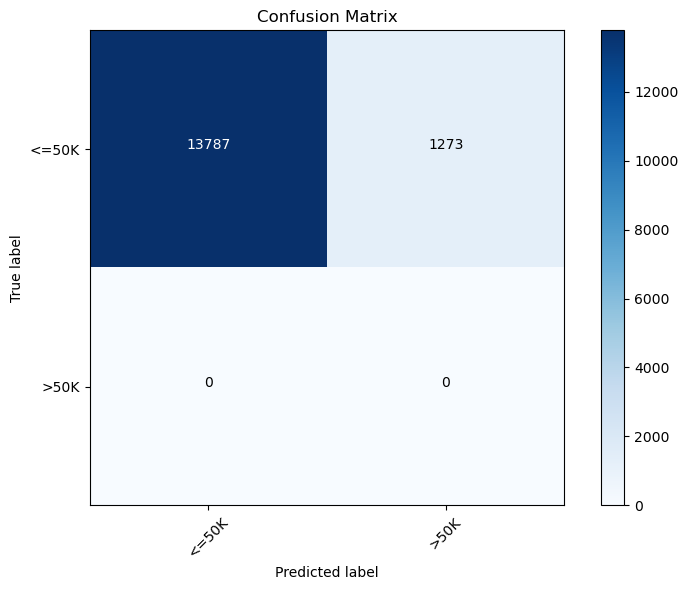

In [12]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['<=50K', '>50K'], rotation=45)
plt.yticks(tick_marks, ['<=50K', '>50K'])

# Add labels to the confusion matrix image.
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f'{cm[i, j]}', horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()